# Assignment 1 : Dataset Preprocessing and Mini-Batch Generation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# Fixing a random seed so that results are reproducible
SEED = 42

# Step 1: Load and Visualize CIFAR-10

In [ ]:
def load_cifar10_and_normalize():
    """
    Loads CIFAR-10 and normalizes the pixel values to [0, 1].
    CIFAR-10 images are originally uint8 in [0, 255].
    We convert to float32 and divide by 255.
    """
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # We will use x_train, y_train for splitting.

    # uint8 -> float32 conversion
    x_train = x_train.astype(np.float32)

    # Normalize pixels to [0, 1]
    x_train = x_train / 255.0

    # y_train from shape (N, 1) to (N,)
    y_train = y_train.reshape(-1).astype(np.int64)

    return x_train, y_train


def print_basic_info(x, y):

    # Prints shape, dtype, and value range.

    print("\n\nDataset Info\n")
    print("x shape:", x.shape)
    print("x dtype:", x.dtype)
    print("x min/max:", x.min(), x.max())
    print("y shape:", y.shape)
    print("y dtype:", y.dtype)
    print("unique classes:", np.unique(y))


def show_16_random_images(x, y, seed=42):
    # Shows 16 random images in a 4x4 grid.
    rng = np.random.default_rng(seed)
    random_indices = rng.choice(len(x), size=16, replace=False)

    print("16 random images in a 4x4 grid.\n")
    plt.figure(figsize=(6, 6))
    for i, idx in enumerate(random_indices):
        plt.subplot(4, 4, i + 1)
        plt.imshow(x[idx])
        plt.title(f"y={y[idx]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Dataset Info

x shape: (50000, 32, 32, 3)
x dtype: float32
x min/max: 0.0 1.0
y shape: (50000,)
y dtype: int64
unique classes: [0 1 2 3 4 5 6 7 8 9]
16 random images in a 4x4 grid.



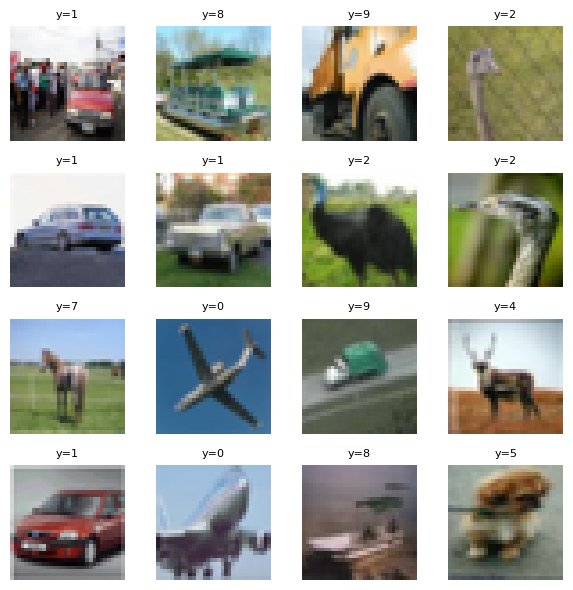

In [ ]:
# Run step 1
x, y = load_cifar10_and_normalize()
print_basic_info(x, y)
show_16_random_images(x, y, seed=SEED)

# Step 2: Implement Dataset Splitting Methods

In [ ]:
def holdout_split_indices(num_samples, train_ratio=0.8, seed=42):
    """
    Hold-out split:
    Shuffle all indices, then take first train_ratio portion as training.
    Remaining becomes validation.

    Returns:
        train_indices, val_indices
    """
    rng = np.random.default_rng(seed)

    all_indices = np.arange(num_samples)
    rng.shuffle(all_indices)

    split_point = int(train_ratio * num_samples)

    train_indices = all_indices[:split_point]
    val_indices = all_indices[split_point:]

    return train_indices, val_indices


def kfold_split_indices(num_samples, k=5, fold_id=0, seed=42):
    """
    K-fold split:
    1) Shuffle indices
    2) Split into k approximately equal folds
    3) Choose one fold as validation (fold_id)
    4) Remaining folds combined as training

    Returns:
        train_indices, val_indices
    """

    rng = np.random.default_rng(seed)

    all_indices = np.arange(num_samples)
    rng.shuffle(all_indices)

    folds = np.array_split(all_indices, k)

    val_indices = folds[fold_id]
    train_indices = np.concatenate([folds[i] for i in range(k) if i != fold_id])

    return train_indices, val_indices


def bootstrap_split_indices(num_samples, seed=42):
    """
    Bootstrap split:
    - Training indices are sampled with replacement (size = num_samples)
      So duplicates are expected.
    - Validation indices are the "out-of-bag" samples:
      those indices that were never chosen.

    Returns:
        train_indices (with duplicates possible),
        val_indices (out-of-bag, unique)
    """
    rng = np.random.default_rng(seed)

    # Sample with replacement for training
    train_indices = rng.integers(low=0, high=num_samples, size=num_samples)

    # Find out-of-bag samples
    chosen_mask = np.zeros(num_samples, dtype=bool)
    chosen_mask[train_indices] = True

    val_indices = np.where(chosen_mask == False)[0]
    return train_indices, val_indices


In [ ]:
# Test splitting methods
N = len(x)
print("\n=== Split method checks ===")

# Hold-out example
train_idx_h, val_idx_h = holdout_split_indices(N, train_ratio=0.8, seed=SEED)
print("Hold-out train size:", len(train_idx_h), "val size:", len(val_idx_h))
print("intersection = ", len(np.intersect1d(train_idx_h, val_idx_h)))

# K-fold example
train_idx_k, val_idx_k = kfold_split_indices(N, k=5, fold_id=0, seed=SEED)
print("\n\nK-fold train size:", len(train_idx_k), "val size:", len(val_idx_k))
print("intersection = ", len(np.intersect1d(train_idx_k, val_idx_k)))

# Bootstrap example
train_idx_b, val_idx_b = bootstrap_split_indices(N, seed=SEED)
print("\n\nBootstrap train size:", len(train_idx_b), "val(OOB) size:", len(val_idx_b))
print("unique train samples:", len(np.unique(train_idx_b)), "(duplicates expected)")
print("intersection = ", len(np.intersect1d(np.unique(train_idx_b), val_idx_b)))


# One actual train/val split for later batching (use hold-out)
x_train = x[train_idx_h]
y_train = y[train_idx_h]
x_val = x[val_idx_h]
y_val = y[val_idx_h]

print("\nTrain arrays:", x_train.shape, y_train.shape)
print("Val arrays:  ", x_val.shape, y_val.shape)


=== Split method checks ===
Hold-out train size: 40000 val size: 10000
intersection =  0


K-fold train size: 40000 val size: 10000
intersection =  0


Bootstrap train size: 50000 val(OOB) size: 18313
unique train samples: 31687 (duplicates expected)
intersection =  0

Train arrays: (40000, 32, 32, 3) (40000,)
Val arrays:   (10000, 32, 32, 3) (10000,)


#Step 3: Implement a Mini-Batch Generator Using yield

In [ ]:
def minibatch_generator(x_train, y_train, batch_size=64, seed=42):
    """
    A Python generator that yields (x_batch, y_batch) repeatedly.

    Behavior:
    - We go sequentially through the dataset.
    - If the next batch would exceed the dataset length:
        1) Shuffle indices
        2) Reset pointer to 0
        3) Continue yielding batches of full batch_size
    """

    rng = np.random.default_rng(seed)

    n = len(x_train)

    # We shuffle via indices to avoid copying the whole dataset
    perm = np.arange(n)

    # i = where we are currently reading from
    i = 0

    while True:
        # If we don't have enough samples left for a full batch, shuffle and restart
        if i + batch_size > n:
            rng.shuffle(perm)
            i = 0

        batch_indices = perm[i:i + batch_size]

        x_batch = x_train[batch_indices]
        y_batch = y_train[batch_indices]

        i += batch_size

        yield x_batch, y_batch


In [ ]:
# Quick test: take a few batches
print("\n=== Mini-batch generator test ===")
gen = minibatch_generator(x_train, y_train, batch_size=64, seed=SEED)

for i in range(5):
    xb, yb = gen.__next__()
    print(f"Batch {i+1}: x={xb.shape}, y={yb.shape}, x_min={xb.min():.4f}, x_max={xb.max():.4f}")

# Testing the special case quickly by using a small dataset
print("\n=== Special-case test (small dataset) ===")
x_small = x_train[:100]
y_small = y_train[:100]
gen_small = minibatch_generator(x_small, y_small, batch_size=64, seed=SEED)

# batch1 uses 64 samples, batch2 would exceed 100 -> triggers shuffle+reset but still returns full batch
for i in range(2):
    xb, yb = gen_small.__next__()
    print(f"Batch {i+1}: x={xb.shape}, y={yb.shape}, x_min={xb.min():.4f}, x_max={xb.max():.4f}")
print("Second batch is still same size")



=== Mini-batch generator test ===
Batch 1: x=(64, 32, 32, 3), y=(64,), x_min=0.0000, x_max=1.0000
Batch 2: x=(64, 32, 32, 3), y=(64,), x_min=0.0000, x_max=1.0000
Batch 3: x=(64, 32, 32, 3), y=(64,), x_min=0.0000, x_max=1.0000
Batch 4: x=(64, 32, 32, 3), y=(64,), x_min=0.0000, x_max=1.0000
Batch 5: x=(64, 32, 32, 3), y=(64,), x_min=0.0000, x_max=1.0000

=== Special-case test (small dataset) ===
Batch 1: x=(64, 32, 32, 3), y=(64,), x_min=0.0000, x_max=1.0000
Batch 2: x=(64, 32, 32, 3), y=(64,), x_min=0.0000, x_max=1.0000
Second batch is still same size
